<a href="https://colab.research.google.com/github/aflita/image-captioning-flickr8k/blob/master/Inception_LSTM_Flickr8k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
os.environ['KAGGLE_USERNAME'] = 'aflita'
os.environ['KAGGLE_KEY'] = 'cad9302366db38692e6dfc19fee87783'

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
import tensorflow as tf
import numpy as np
import pickle
import os
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import numpy as np
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from IPython.display import Image, display
#from keras.models import Model

Using TensorFlow backend.


In [5]:
!kaggle datasets download -d shadabhussain/flickr8k
!kaggle datasets download -d rtatman/glove-global-vectors-for-word-representation

 99% 2.12G/2.13G [00:20<00:00, 124MB/s]
100% 2.13G/2.13G [00:20<00:00, 109MB/s]
 99% 453M/458M [00:04<00:00, 112MB/s]
100% 458M/458M [00:04<00:00, 105MB/s]


In [6]:
!unzip -q flickr8k.zip -d .
!unzip -q glove-global-vectors-for-word-representation.zip -d .

In [7]:
# Read Image Folder
image_folder = '/content/Flickr_Data/Flickr_Data/Images'
# Read Annotation Folder
annotation_file = '/content/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'
# Read Training File
train_file = '/content/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
# Read Validation File
val_file = '/content/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.devImages.txt'
# Read Test File
test_file = '/content/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt'
# Read GloVe File
glove_file = '/content/glove.6B.50d.txt'

In [8]:
unique_train = open(train_file, 'r').read().splitlines()
unique_val = open(val_file, 'r').read().splitlines()
unique_test = open(test_file, 'r').read().splitlines()
annotations = open(annotation_file,'r').read().splitlines()

In [9]:
# Collect Dataset
import re

def collect_list(unique_set):
  data = []
  for idx, el in enumerate(annotations):
    # Split Image ID with Captions
    fname, cap = re.split("#[0-9][\t]", el)
    cap = cap.split()
    cap = [w for w in cap if len(w)>1]
    cap = ' '.join(cap)
    cap = '<start> ' + cap + ' <end>'
    cap = cap.lower()
    if fname in unique_set:
      data.append([fname,cap])
  return data

train_set = collect_list(unique_train)
val_set = collect_list(unique_val)
test_set = collect_list(unique_test)

print('Collected Train Sets: %d' %len(train_set))
print('Collected Val Sets: %d' %len(val_set))
print('Collected Test Sets: %d' %len(test_set))
print('\n')
print('Unique Train Sets: %d' %len(unique_train))
print('Unique Val Sets: %d' %len(unique_val))
print('Unique Test Sets: %d' %len(unique_test))

Collected Train Sets: 30000
Collected Val Sets: 5000
Collected Test Sets: 5000


Unique Train Sets: 6000
Unique Val Sets: 1000
Unique Test Sets: 1000


**Preprocess Image**

In [10]:
# Image Model
from keras.applications.inception_v3 import InceptionV3, preprocess_input

img_model = tf.keras.applications.InceptionV3(weights='imagenet')

img_model = tf.keras.Model(inputs = img_model.input,
                          outputs = img_model.layers[-2].output)

96116736/96112376 [==============================] - 1s 0us/step


In [11]:
def preprocess_image(file):
  #file = os.path.join(image_folder, file)
  image = load_img(file, target_size=(299, 299, 3))
  image = img_to_array(image)
  image = preprocess_input(image)
  image = np.expand_dims(image, axis=0)    
  return image

def extract_feature(unique):
  features = {}
  for i, name in enumerate(unique):
      file = os.path.join(image_folder, name)
      image = preprocess_image(file)
      feature = img_model.predict(image)
      features[name] = np.reshape(feature, feature.shape[1])
      #print('>%s' % name)
  print('Features Extracted: %d' %len(features))
  return features

In [12]:
# Optional
# Extract Image Features
train_features = extract_feature(unique_train)
val_features = extract_feature(unique_val)

Features Extracted: 6000
Features Extracted: 1000


In [13]:
# Save Feature
pickle.dump(train_features, open('train_features.pkl','wb'))
pickle.dump(val_features, open('val_features.pkl','wb'))

In [ ]:
# Load Features if Available
train_features = pickle.load(open('/content/gdrive/My Drive/train_features.pkl', 'rb'))
val_features = pickle.load(open('/content/gdrive/My Drive/val_features.pkl', 'rb'))

In [16]:
print(train_features['3296150666_aae2f64348.jpg'].shape), print(len(train_features)), print(len(val_features))

(2048,)
6000
1000


(None, None, None)

In [51]:
train_features

{'2513260012_03d33305cf.jpg': array([0.08447909, 0.09467594, 0.09229989, ..., 0.07690588, 1.4561852 ,
        0.4511912 ], dtype=float32),
 '2903617548_d3e38d7f88.jpg': array([0.17603166, 0.5156659 , 0.41329545, ..., 0.6511053 , 0.35608903,
        0.9773246 ], dtype=float32),
 '3338291921_fe7ae0c8f8.jpg': array([0.1618719 , 0.13512504, 0.04707861, ..., 0.3525015 , 0.25436476,
        0.389965  ], dtype=float32),
 '488416045_1c6d903fe0.jpg': array([0.4500727 , 0.07103869, 0.14107412, ..., 0.51039034, 1.1378498 ,
        0.47370857], dtype=float32),
 '2644326817_8f45080b87.jpg': array([0.26103935, 0.85202   , 0.0301678 , ..., 0.05509197, 1.0150241 ,
        0.93701696], dtype=float32),
 '218342358_1755a9cce1.jpg': array([0.73624283, 0.16550522, 0.12633786, ..., 0.32769376, 0.28599402,
        0.58553326], dtype=float32),
 '2501968935_02f2cd8079.jpg': array([0.15158756, 0.06291358, 1.0291828 , ..., 0.07257836, 1.0984015 ,
        0.9973053 ], dtype=float32),
 '2699342860_5288e203ea.jpg':

**Preprocess Captions**

In [17]:
allwords = []
_ = [allwords.append(i) for train in train_set for i in train[1].split()]
_ = [allwords.append(i) for val in val_set for i in val[1].split()]
_ = [allwords.append(i) for test in test_set for i in test[1].split()]

len(allwords)

449784

In [18]:
from collections import Counter
freq = dict(Counter(allwords))
freq = sorted(freq.items(), reverse=True, key=lambda x:x[1])

print('Vocabulary Size: %d' %len(freq))

Vocabulary Size: 8776


In [19]:
threshold = 2 # Choose Minimum 15 Occurence in Corpus
freq = [x for x in freq if x[1]>threshold]
allwords = [x[0] for x in freq]

In [20]:
# Token
num_words = 4000
oov = '<unk>'
filt = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ '

tokenizer = Tokenizer(num_words+1, oov_token = oov, filters = filt)
tokenizer.fit_on_texts(allwords)
word2index = tokenizer.word_index

vocab_size = len(word2index) + 1
print('Reduced Vocabulary Size: %d' % vocab_size)
max_length = max_length = max(len(train_set[i][1].split()) for i in range(len(train_set)))
print('Description Length: %d' % max_length)

Reduced Vocabulary Size: 3975
Description Length: 34


In [21]:
# Reverse Index to Word
index2word = dict([(value, key) for (key, value) in word2index.items()])

# Set Padding as Zero
word2index['<pad>'] = 0
index2word[0] = '<pad>'

In [ ]:
import json
json.dump(index2word, open('index2word.json','w'))
json.dump(word2index, open('word2index.json','w'))

In [22]:
# Adding GloVe Vector
embeddings = {}
f = open(glove_file, encoding='utf8')

for line in f:
    words = line.split()
    word_embeddings = np.array(words[1:], dtype='float')
    embeddings[words[0]] = word_embeddings

f.close()
len(embeddings)

400000

In [23]:
embedding_matrix = np.zeros((len(word2index) + 1, 50))

for word, index in word2index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

print(embedding_matrix.shape)

(3976, 50)


In [24]:
train_captions = [train[1] for train in train_set]
val_captions = [val[1] for val in val_set]

# Fit Token to Texts
train_seq = tokenizer.texts_to_sequences(train_captions)
val_seq = tokenizer.texts_to_sequences(val_captions)

In [25]:
def create_sequence(sequence_name):
  padded_sequences, subsequent_words = [], []

  for seq in sequence_name:
      partial_seqs = []
      next_words = []
      for i in range(1, len(seq)):
        partial_seqs.append(seq[:i])
        next_words.append(seq[i])
      padded_partial_seqs = pad_sequences(partial_seqs, max_length, padding='post')

      next_words_1hot = np.zeros([len(next_words), vocab_size], dtype=np.bool)
      
      #Vectorization
      for i,next_word in enumerate(next_words):
          next_words_1hot[i, next_word] = 1
          
      padded_sequences.append(padded_partial_seqs)
      subsequent_words.append(next_words_1hot)
      
  padded_sequences = np.asarray(padded_sequences)
  subsequent_words = np.asarray(subsequent_words)
  return padded_sequences, subsequent_words

In [26]:
padded_sequences, subsequent_words = create_sequence(train_seq)
vpadded_sequences, vsubsequent_words = create_sequence(val_seq)

print(padded_sequences.shape)
print(subsequent_words.shape)
print(vpadded_sequences.shape)
print(vsubsequent_words.shape)

(30000,)
(30000,)
(5000,)
(5000,)


In [27]:
num_of_images = 6000

In [ ]:
captions = np.zeros([0, max_length])
next_words = np.zeros([0, vocab_size])

# Store Captions and Next Words to Disk

for i in range(num_of_images):
  captions = np.concatenate([captions, padded_sequences[i]])
  next_words = np.concatenate([next_words, subsequent_words[i]])
  print(i)
  
np.save("captions.npy", captions)
np.save("next_words.npy", next_words)

print(captions.shape)
print(next_words.shape)

In [29]:
imgs = []

for i in range(len(train_set)):
    if train_set[i][0] in train_features.keys():
      imgs.append(list(train_features[train_set[i][0]]))

imgs = np.asarray(imgs)

images = []
for ix in range(6000):#num_of_images
    for iy in range(padded_sequences[ix].shape[0]):
        images.append(imgs[ix])
        
images = np.asarray(images)
np.save("images.npy", images)

print(images.shape)

(61800, 2048)


In [30]:
vcaptions = np.zeros([0, max_length])
vnext_words = np.zeros([0, vocab_size])

# Store Captions and Next Words to Disk

for i in range(1000):
  vcaptions = np.concatenate([vcaptions, vpadded_sequences[i]])
  vnext_words = np.concatenate([vnext_words, vsubsequent_words[i]])
  
np.save("vcaptions.npy", vcaptions)
np.save("vnext_words.npy", vnext_words)

print(vcaptions.shape)
print(vnext_words.shape)

(10560, 34)
(10560, 3975)


In [31]:
imgs = []

for i in range(len(val_set)):
    if val_set[i][0] in val_features.keys():
      imgs.append(list(val_features[val_set[i][0]]))

imgs = np.asarray(imgs)
#print(imgs.shape)

images = []

for ix in range(1000):#num_of_images
    for iy in range(vpadded_sequences[ix].shape[0]):
        images.append(imgs[ix])
        
images = np.asarray(images)
np.save("vimages.npy", images)
print(images.shape)

(10560, 2048)


**Model**

In [32]:
captions = np.load("captions.npy")
next_words = np.load("next_words.npy")
images = np.load("images.npy")

print(captions.shape)
print(next_words.shape)
print(images.shape)

(61800, 34)
(61800, 3975)
(61800, 2048)


In [33]:
vcaptions = np.load("vcaptions.npy")
vnext_words = np.load("vnext_words.npy")
vimages = np.load("vimages.npy")
print(vcaptions.shape)
print(vnext_words.shape)
print(vimages.shape)

(10560, 34)
(10560, 3975)
(10560, 2048)


In [37]:
from keras.layers.merge import add
from keras.layers import Input
from keras.utils import plot_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.models import Model

# Image Model
in_img_feats = Input(shape=(2048,))
in_img_1 = Dropout(0.3)(in_img_feats)
in_img_2 = Dense(256, activation='relu')(in_img_1)

# Caption Model
in_caps = Input(shape=(max_length,))
in_cap_1 = Embedding(input_dim=len(word2index) + 1, output_dim=50, mask_zero=True)(in_caps)
in_cap_2 = Dropout(0.3)(in_cap_1)
in_cap_3 = LSTM(256)(in_cap_2)

# Decoder model
decoder1 = add([in_img_2, in_cap_3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(len(word2index), activation='softmax')(decoder2)

# Tie it together [image, seq] [word]
model = Model(inputs=[in_img_feats, in_caps], outputs=outputs)

model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 34, 50)       198800      input_5[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 2048)         0           input_4[0][0]                    
____________________________________________________________________________________________

In [38]:
from keras.callbacks import ModelCheckpoint

# define checkpoint callback
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [39]:
hist = model.fit([images, captions], next_words, batch_size=309, epochs=20, callbacks=[checkpoint], validation_data=([vimages, vcaptions], vnext_words))

Train on 61800 samples, validate on 10560 samples
Epoch 1/20
61800/61800 [==============================] - 171s 3ms/step - loss: 5.2702 - accuracy: 0.1526 - val_loss: 4.8063 - val_accuracy: 0.1927

Epoch 00001: val_loss improved from inf to 4.80630, saving model to model-ep001-loss5.270-val_loss4.806.h5
Epoch 2/20
61800/61800 [==============================] - 169s 3ms/step - loss: 4.3435 - accuracy: 0.2198 - val_loss: 4.4319 - val_accuracy: 0.2237

Epoch 00002: val_loss improved from 4.80630 to 4.43190, saving model to model-ep002-loss4.344-val_loss4.432.h5
Epoch 3/20
61800/61800 [==============================] - 172s 3ms/step - loss: 3.9066 - accuracy: 0.2494 - val_loss: 4.2814 - val_accuracy: 0.2409

Epoch 00003: val_loss improved from 4.43190 to 4.28142, saving model to model-ep003-loss3.907-val_loss4.281.h5
Epoch 4/20
61800/61800 [==============================] - 169s 3ms/step - loss: 3.5803 - accuracy: 0.2712 - val_loss: 4.2551 - val_accuracy: 0.2510

Epoch 00004: val_loss imp

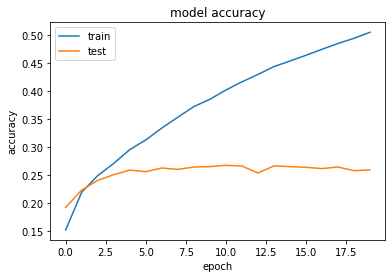

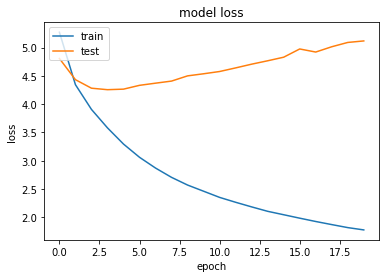

In [40]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
img_model.save('img_model_latest.h5')
model.save('lang_model_latest.h5')

In [ ]:
!mkdir -p saved_model2
model.save('saved_model2/my_model') 

In [15]:
!cp -r /content/val_features.pkl '/content/gdrive/My Drive/'

**Predict**

In [43]:
import json
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
import random

In [ ]:
model = tf.keras.models.load_model('/content/gdrive/My Drive/saved_model2/my_model')

In [ ]:
index2word = json.load(open('/content/gdrive/My Drive/index2word.json'))
word2index = json.load(open('/content/gdrive/My Drive/word2index.json'))

In [45]:
# Image Model
from keras.applications.inception_v3 import InceptionV3, preprocess_input

img_model = tf.keras.applications.InceptionV3(weights='imagenet')

img_model = tf.keras.Model(inputs = img_model.input,
                          outputs = img_model.layers[-2].output)

In [48]:
def preprocess_image(file):
  image = load_img(file, target_size=(299, 299, 3))
  image = img_to_array(image)
  image = preprocess_input(image)
  image = np.expand_dims(image, axis=0)    
  return image

def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word2index[i] for i in start_word]
        par_caps = pad_sequences([par_caps], maxlen=max_length, padding='post')
        preds = model.predict([np.array([image]), np.array(par_caps)])
        word_pred = index2word[(np.argmax(preds[0]))]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_length:
            break
            
    return ' '.join(start_word[1:-1])

In [50]:
max_length = 34
bleus = []

# Calculate Bleu Means
for t in unique_val:
  test_img_path = os.path.join(image_folder, t)
  real_cap = next(y for x,y in val_set if x==t)
  image = preprocess_image(test_img_path)
  feature = img_model.predict(image)
  feature = np.reshape(feature, feature.shape[1])

  Argmax_Search = predict_captions(feature)
  pic = Image(filename=test_img_path)
  #display(pic)

  s_real = real_cap.split()
  s_real = s_real[1: -1]
  s_pred = Argmax_Search.split()
  bleu = sentence_bleu([s_real], s_pred)

  #print('Real Captions: {}'.format(''.join(real_cap)))
  #print('Predicted Captions: {}'.format(Argmax_Search))
  #print('BLEU: {}'.format(bleu))
  #print('\n')
  bleus.append(bleu)

print("Mean BLEU {}".format(np.mean(bleus)))

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Mean BLEU 0.3549605242422966


**Without Embedding**

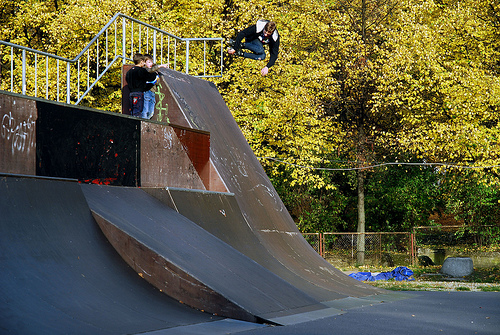

Real Captions: <start> man going skating down slide while two kids look on <end>
Predicted Captions: the waterskier gazes the the distance


BLEU: 0


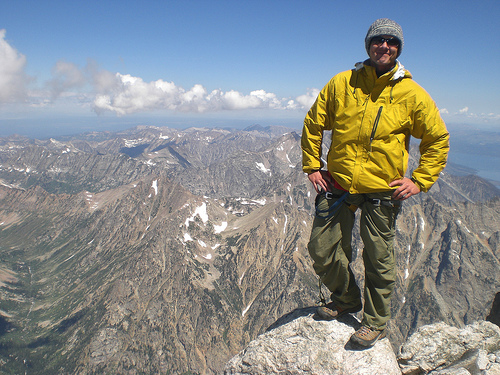

Real Captions: <start> man wearing yellow coat stands at the peak of mountain <end>
Predicted Captions: man with backpack and backpack stands on mountain


BLEU: 0.6094445482670285


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


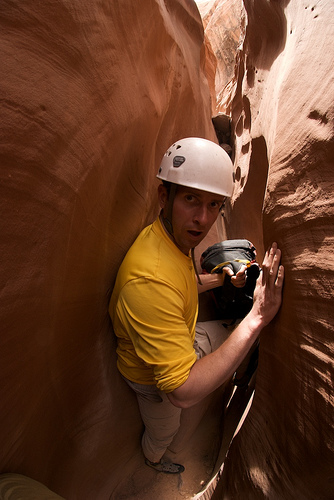

Real Captions: <start> rock climber standing in crevasse <end>
Predicted Captions: man wearing headband is climbing up cliff


BLEU: 0


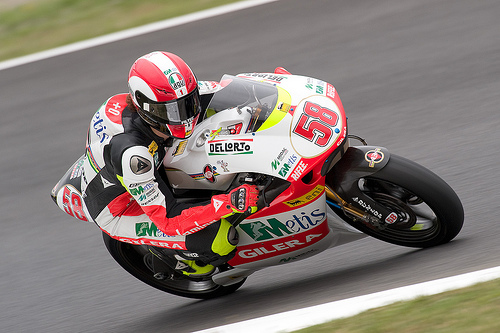

Real Captions: <start> red and white motorcycle is being ridden around bend on racetrack <end>
Predicted Captions: the motorcyclist is wearing red helmet and helmet is turning sharp


BLEU: 0.7226568811456053


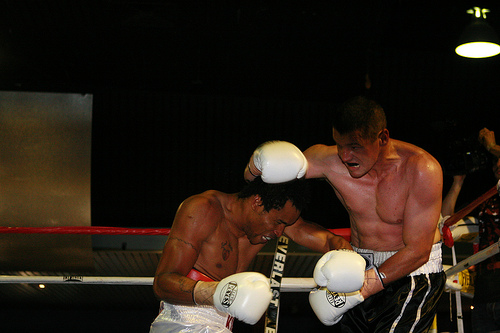

Real Captions: <start> two men wearing white boxing gloves are in ring <end>
Predicted Captions: the little boy is wearing blue shirt and orange shirt and orange shirt with his head open


BLEU: 0.4924790605054523


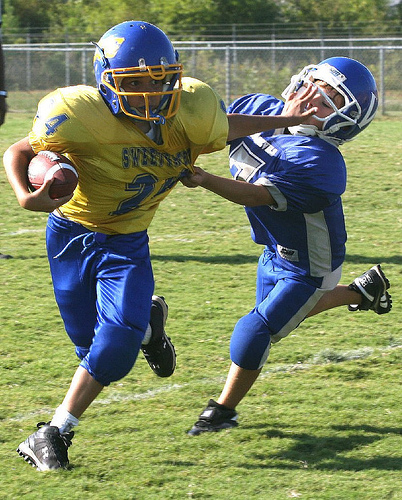

Real Captions: <start> two young football players wearing blue and yellow uniforms fight for the ball <end>
Predicted Captions: player player cooling off the the


BLEU: 0.19896894256029013


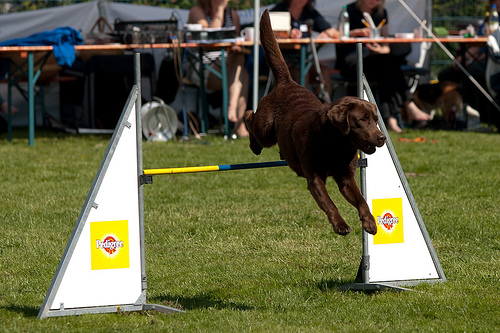

Real Captions: <start> brown dog jumping over hurdle <end>
Predicted Captions: brown dog is running alongside the black dog


BLEU: 0.43472087194499137


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


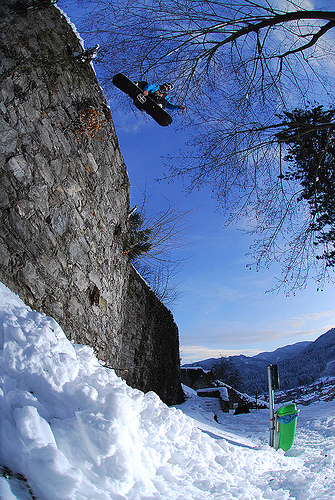

Real Captions: <start> the snowboarder is doing jump <end>
Predicted Captions: the sun climber is sitting in the snow with the sun


BLEU: 0.6529942057256104


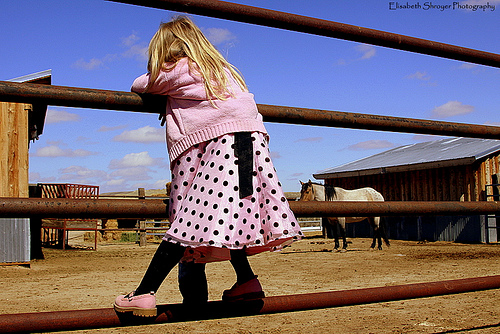

Real Captions: <start> girl in pink polka dots looks at horse <end>
Predicted Captions: little girl in pink shirt jumps on the playground


BLEU: 0.3303164318013807


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


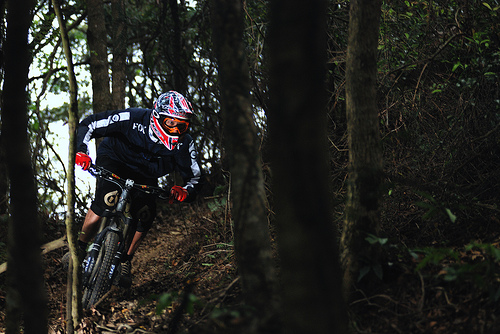

Real Captions: <start> mountain biker wearing colorful helmet rides downhill <end>
Predicted Captions: blurry of mountain biker through the woods


BLEU: 0.4671379777282001


In [49]:
test_img = []
for i in range(10):
  r = random.randint(0,4999)
  test_img = test_set[r][0]
  test_img_path = os.path.join(image_folder, test_img)
  real_cap = test_set[r][1]

  image = preprocess_image(test_img_path)
  feature = inception.predict(image)
  feature = np.reshape(feature, feature.shape[1])
  
  Argmax_Search = predict_captions(feature)
  pic = Image(filename=test_img_path)
  display(pic)

  print('Real Captions: {}'.format(real_cap))
  print('Predicted Captions: {}'.format(Argmax_Search))
  print('\n')

  s_real = real_cap.split()
  s_real = s_real[1: -1]
  s_pred = Argmax_Search.split()
  bleu = sentence_bleu([s_real], s_pred)
  print('BLEU: {}'.format(bleu))